<a href="https://colab.research.google.com/github/chang-heekim/Oxford-Pet-Dataset/blob/main/Oxford_Pet_Dataset_Multi_Classification_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from glob import glob
from datetime import datetime

import cv2
import xml.etree.ElementTree as et
from matplotlib.patches import Rectangle

import os
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
import torch

from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch import nn, optim
from torchsummary import summary
import transformers
import torch.nn.functional as F

# Set up Device & Preprocessing Dataset

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/oxford_pet/annotations/list.txt', skiprows=6, delimiter=' ', header=None)
df.columns = ['file_name', 'id', 'species', 'breed']

In [ ]:
df.head()

,file_name,id,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [ ]:
image_dir = '/content/drive/MyDrive/dataset/oxford_pet/images/'
bbox_dir = '/content/drive/MyDrive/dataset/oxford_pet/annotations/xmls/'
seg_dir = '/content/drive/MyDrive/dataset/oxford_pet/annotations/trimaps/'

In [ ]:
image_files = glob(image_dir + '*.jpg')
bbox_files = glob(bbox_dir + '*.xml')
seg_files = glob(seg_dir + '*.png')
len(image_files), len(bbox_files), len(seg_files)

(7378, 3685, 7390)

In [ ]:
labels = []
delete = []
classes = {}
for idx, img_file in enumerate(image_files):
    file_name = img_file.split('/')[-1].split('.')[0]
    id = df.loc[df['file_name'] == file_name]['id'].values
    if len(id) == 0:
        delete.append(idx)
        labels.append(-1)
    else:
        classes[id[0]] = file_name.split('_')[0]
        labels.extend(id - 1)

In [ ]:
classes

{1: 'Abyssinian',
 2: 'american',
 3: 'american',
 4: 'basset',
 5: 'beagle',
 6: 'Bengal',
 7: 'Birman',
 8: 'Bombay',
 9: 'boxer',
 10: 'British',
 11: 'chihuahua',
 12: 'Egyptian',
 13: 'english',
 14: 'english',
 15: 'german',
 16: 'great',
 17: 'havanese',
 18: 'japanese',
 19: 'keeshond',
 20: 'leonberger',
 21: 'Maine',
 22: 'miniature',
 23: 'newfoundland',
 24: 'Persian',
 25: 'pomeranian',
 26: 'pug',
 27: 'Ragdoll',
 28: 'Russian',
 29: 'saint',
 30: 'samoyed',
 31: 'scottish',
 32: 'shiba',
 33: 'Siamese',
 34: 'Sphynx',
 35: 'staffordshire',
 36: 'wheaten',
 37: 'yorkshire'}

In [ ]:
i = 0
for idx in delete:
    image_files.pop(idx)
    labels.pop(idx - i)
    i += 1
len(labels), len(image_files)

(7346, 7346)

# Define Dataset Class

In [ ]:
class Oxford_Dataset(Dataset):
    def __init__(self, img_dir, labels, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.labels = labels
    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(self.labels)
        return image, label

In [ ]:
transform_1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomHorizontalFlip(p=1)
])

dataset_1 = Oxford_Dataset(img_dir=image_files, labels=labels, transform=transform_1)
dataset_2 = Oxford_Dataset(img_dir=image_files, labels=labels, transform=transform_2)

dataset = dataset_1 + dataset_2

train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
len(dataset)

14692

In [ ]:
len(train_dataset), train_dataset[1]

(13222, (tensor([[[ 1.9407,  1.9407,  1.9578,  ..., -1.6042, -1.6727, -1.6384],
           [ 1.9407,  1.9749,  1.9920,  ..., -1.6213, -1.6727, -1.6213],
           [ 1.9407,  1.9749,  1.9920,  ..., -1.6727, -1.6727, -1.6384],
           ...,
           [-1.1418, -1.1247, -1.1418,  ..., -1.0733, -1.1760, -1.1075],
           [-1.1247, -1.1075, -1.1075,  ..., -1.1589, -1.1932, -1.2103],
           [-1.1247, -1.1247, -1.1418,  ..., -1.1932, -1.2274, -1.1760]],
  
          [[ 1.9384,  1.9384,  1.9734,  ..., -1.8256, -1.8256, -1.8256],
           [ 1.9734,  1.9559,  1.9734,  ..., -1.8256, -1.8431, -1.8431],
           [ 1.9909,  1.9734,  1.9734,  ..., -1.8256, -1.8081, -1.8431],
           ...,
           [-0.9328, -0.9153, -0.9153,  ..., -1.0903, -1.1604, -1.1078],
           [-0.8978, -0.8978, -0.9153,  ..., -1.1779, -1.1253, -1.2129],
           [-0.9328, -0.9328, -0.9328,  ..., -1.2304, -1.1604, -1.1954]],
  
          [[ 1.8034,  1.7860,  1.8034,  ..., -1.8044, -1.8044, -1.8044],
    

In [ ]:
train_batch_size = 128
val_batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=2)

In [ ]:
for idx, sample_batch in enumerate(train_loader):
    print(sample_batch[0].shape)
    print(sample_batch[1].shape)
    print(sample_batch[0].dtype)
    print(sample_batch[1].dtype)
    break

torch.Size([128, 3, 224, 224])
torch.Size([128])
torch.float32
torch.int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


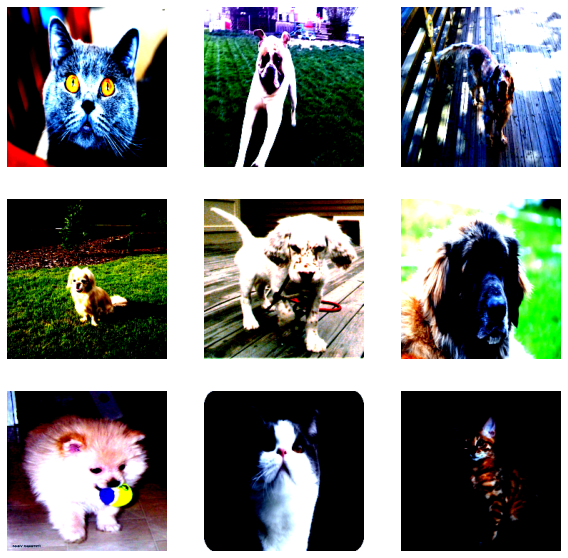

In [ ]:
sample = next(iter(train_loader))
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(torch.permute(sample[0][i], (1, 2, 0)))
    plt.axis('off')
plt.show()

# Define ResNet

In [ ]:
class BasicBlock(nn.Module):
    mul = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.shortcut = nn.Sequential()

        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.block(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class BottleNeck(nn.Module):
    mul = 4
    def __init__(self, in_channels, out_channels, stride):
        super(BottleNeck, self).__init__()
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * self.mul, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * self.mul)
        )

        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels * self.mul:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.mul, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.mul)
        )
            
    def forward(self, x):
        out = self.bottleneck(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=37):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.maxpool1 = nn.MaxPool2d(3, 2)
        
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear1 = nn.Linear(512 * block.mul, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.mul
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        return out

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

# Define Model & Optimizer & Loss Function & Learning Rate Scheduler

In [ ]:
lr = 1e-2
epochs = 50

model = ResNet50().to(device)
model_name = type(model).__name__
summary(model, (3, 224, 224))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

num_warmup_steps = (len(dataset) // train_batch_size) * 5
num_total_steps = (len(dataset) // train_batch_size) * epochs

scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_total_steps)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 64, 55, 55]           4,096
       BatchNorm2d-5           [-1, 64, 55, 55]             128
              ReLU-6           [-1, 64, 55, 55]               0
            Conv2d-7           [-1, 64, 55, 55]          36,864
       BatchNorm2d-8           [-1, 64, 55, 55]             128
              ReLU-9           [-1, 64, 55, 55]               0
           Conv2d-10          [-1, 256, 55, 55]          16,384
      BatchNorm2d-11          [-1, 256, 55, 55]             512
           Conv2d-12          [-1, 256, 55, 55]          16,384
      BatchNorm2d-13          [-1, 256, 55, 55]             512
       BottleNeck-14          [-1, 256,

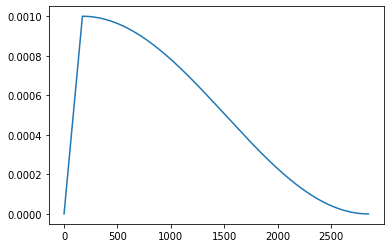

In [ ]:
lrs = []
for i in range(num_total_steps):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    
plt.plot(lrs)
plt.show()

# Define Early Stopping

In [ ]:
# With some modifications, source is from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.ckpt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.ckpt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        filename = self.path.split('/')[-1]
        save_dir = os.path.dirname(self.path)
        torch.save(model, os.path.join(save_dir, f"val_loss-{val_loss}-{filename}"))
        self.val_loss_min = val_loss

# Define Training & Validation Function

In [ ]:
def train(epoch, model, train_loader, loss_fn, optimizer):
    print(f' Epoch: [{epoch}/{epochs}] - Train')
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        current_loss = 0.0
        currnet_correct = 0.0
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        loss = loss_fn(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        current_loss += loss.item() 
        currnet_correct += torch.sum(preds == labels.data) 

        if batch_idx % 10 == 0:
            train_loss = current_loss / train_batch_size
            train_acc = currnet_correct / train_batch_size
            print(f'Current Step: {batch_idx} \tTrain Loss: {train_loss}, Train Accuracy: {train_acc}')
            current_loss = 0.0
            currnet_correct = 0.0
    return train_loss, train_acc

def validation(epoch, model, val_loader, loss_fn):
    print(f' Epoch: [{epoch}/{epochs}] - Validation')
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        val_correct = 0.0
        for val_idx, (val_images, val_labels) in enumerate(val_loader):

            val_images, val_labels = val_images.to(device), val_labels.to(device)
            
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)

            val_loss += loss_fn(val_outputs, val_labels) / val_outputs.shape[0]
            val_correct += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / len(val_loader)

    print(f'Validation step: Val Loss: {val_epoch_loss}, Val Accuracy: {val_epoch_acc}')
    return val_epoch_loss, val_epoch_acc

In [ ]:
log_dir = f"runs/{datetime.now().isoformat(timespec='seconds')}-{model_name}"
model_path = os.path.join(log_dir, 'models')
os.makedirs(model_path, exist_ok=True)

# Training

In [ ]:
train_result = []
val_result = []

early_stopper = EarlyStopping(
    patience=7, verbose=True, path=os.path.join(model_path, "model.ckpt")
)

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(epoch, model, train_loader, loss_fn, optimizer)
    val_loss, val_acc = validation(epoch, model, val_loader, loss_fn)

    # early_stopper(val_loss, model)
    # if early_stopper.early_stop:
    #     break

    train_result.append([train_loss, train_acc])
    val_result.append([val_loss, val_acc])

 Epoch: [1/50] - Train
Current Step: 0 	Train Loss: 0.028954390436410904, Train Accuracy: 0.015625
Current Step: 10 	Train Loss: 0.0285223126411438, Train Accuracy: 0.015625
Current Step: 20 	Train Loss: 0.028938045725226402, Train Accuracy: 0.0625
Current Step: 30 	Train Loss: 0.02852792665362358, Train Accuracy: 0.0703125
Current Step: 40 	Train Loss: 0.026016678661108017, Train Accuracy: 0.1171875
Current Step: 50 	Train Loss: 0.028164410963654518, Train Accuracy: 0.0703125
Current Step: 60 	Train Loss: 0.027318140491843224, Train Accuracy: 0.0703125
Current Step: 70 	Train Loss: 0.026712724938988686, Train Accuracy: 0.109375
Current Step: 80 	Train Loss: 0.025387804955244064, Train Accuracy: 0.1484375
Current Step: 90 	Train Loss: 0.026286963373422623, Train Accuracy: 0.1171875
Current Step: 100 	Train Loss: 0.026674484834074974, Train Accuracy: 0.09375
 Epoch: [1/50] - Validation
Validation step: Val Loss: 0.06537988036870956, Val Accuracy: 0.09057240933179855
 Epoch: [2/50] - Tra

# Visualization Loss & Accuracy

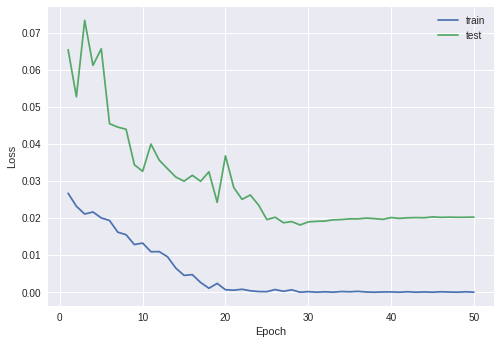

In [ ]:
plt.style.use('seaborn')
plt.plot([i for i in range(1, len(train_result) + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(1, len(val_result) + 1)], [i[0] for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

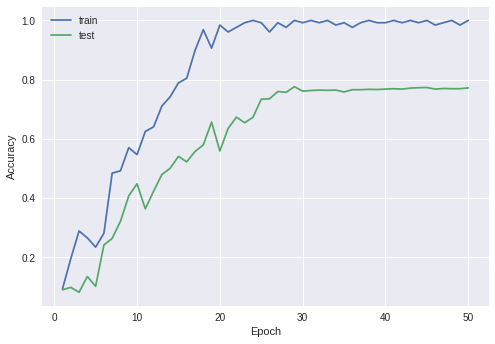

In [ ]:
plt.plot([i for i in range(1, len(train_result) + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(1, len(val_result) + 1)], [i[1] for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()